## Install necessary packages, might also need torch, numpy and sklearn. In Kaggle these are already pre-installed.

In [1]:
!pip install -q monai einops nibabel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 28.9 MB/s eta 0:00:00


### Imports

In [2]:
# imports
from tqdm.auto import tqdm
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, Orientationd,
    Spacingd, CropForegroundd, SpatialPadd, DivisiblePadd,
    ScaleIntensityRangePercentilesd, AsDiscreted,
    RandCropByPosNegLabeld, RandFlipd, RandAffined, RandRotated,
    RandGaussianNoised, RandGaussianSmoothd, DeleteItemsd,
    Activations, AsDiscrete, KeepLargestConnectedComponent
)
from monai.data import PersistentDataset, DataLoader, decollate_batch, list_data_collate, Dataset
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.networks.nets import SegResNet
from monai.losses import DiceCELoss
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
from sklearn.model_selection import train_test_split
import os
import random
import warnings
import shutil
import numpy as np
import torch
import sys
import math
import json
import gc

2026-01-24 17:21:58.940100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769275319.314688      25 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769275319.422494      25 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769275320.454592      25 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769275320.454632      25 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769275320.454635      25 computation_placer.cc:177] computation placer alr

### Setting up

##### Cuda environment settings and CUDA GPU check, also save the number of GPUs in NGPU variable.

In [3]:
# some cuda settings

os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True,max_split_size_mb:128")
warnings.filterwarnings("ignore", message="single channel prediction")
warnings.filterwarnings("ignore", category=FutureWarning)

torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NGPU = torch.cuda.device_count() if torch.cuda.is_available() else 0
print(f"CUDA: {torch.cuda.get_device_name(0) if NGPU else 'CPU'} | GPUs={NGPU}")
if NGPU > 0:
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

CUDA: Tesla T4 | GPUs=2
GPU Memory: 15.83 GB


##### Most hyperparameters, general configuration settings, and data paths are defined in the cell below.

In [4]:
# Configs, all hyperparams, dir paths, model parameters etc...
CONFIG = {
    # dirs
    #
    "images_dir": "/kaggle/input/imagess/volumes/",
    "labels_dir": "/kaggle/input/labels/masks/",
    "cache_dir": "/kaggle/working/cache",
    "best_model_path": "/kaggle/working/best_segres.pth",
    "clear_cache": True,

    # Training hyperparams
    "seed": 121,
    "epochs": 120,
    "batch_size": 1,
    "accum_steps": 4,
    "val_every": 1,

    # optimizer
    "base_lr": 2.5e-5,
    "max_lr": 4e-4,
    "weight_decay": 2e-5,
    "warmup_epochs": 20,
    
    "drop_rate": 0.0,

    # transform settings
    "spacing": (2.0, 2.0, 2.0),
    "roi_size": (96, 96, 64),
    "crop_margin": 8,
    "divisible_pad": (32, 32, 16),

    # val
    "swi_batch_size": 1,
    "overlap": 0.5,
    "init_threshold": 0.5,
    "thr_sweep_every": 5,
    "thr_grid": np.linspace(0.35, 0.65, 5).tolist(),

    # loss weights
    "dice_weight": 1.0,
    "ce_weight": 1.0,


    "patience": 30,
    "min_delta": 0.0,

    # change in pos/neg analogy
    "curriculum_stages": [
        {"epoch_start": 0, "pos": 1, "neg": 0, "desc": "Foreground-only"},
        {"epoch_start": 40, "pos": 3, "neg": 1, "desc": "Mixed sampling"},
        {"epoch_start": 70, "pos": 1, "neg": 1, "desc": "Balanced"},
    ],

    # expo moving average
    "ema_decay": 0.975,
}

##### Below is the pre-processing stack where we apply spatial normalization, intensity scaling, and data augmentation to prepare 3D medical images for model training.

In [5]:
os.makedirs(CONFIG["cache_dir"], exist_ok=True)
if CONFIG["clear_cache"]:
    shutil.rmtree(os.path.join(CONFIG["cache_dir"], "train"), ignore_errors=True)
    shutil.rmtree(os.path.join(CONFIG["cache_dir"], "val"), ignore_errors=True)

# Set seeds
random.seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])
torch.manual_seed(CONFIG["seed"])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CONFIG["seed"])

# transforms

def get_transforms():
    base_transform = Compose([
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        EnsureTyped(keys=["image", "label"], dtype=torch.float32, track_meta=True),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=CONFIG["spacing"], mode=("bilinear", "nearest")),
        ScaleIntensityRangePercentilesd(keys=["image"], lower=2.0, upper=99.9, b_min=0.0, b_max=1.0, clip=True),
        AsDiscreted(keys=["label"], threshold=0.5),
        CropForegroundd(keys=["image", "label"], source_key="label", margin=CONFIG["crop_margin"]),
        SpatialPadd(keys=["image", "label"], spatial_size=CONFIG["roi_size"], method="symmetric"),
        DivisiblePadd(keys=["image", "label"], k=CONFIG["divisible_pad"]),
        EnsureTyped(keys=["image", "label"], dtype=torch.float32, track_meta=False),
        DeleteItemsd(keys=["image_meta_dict", "label_meta_dict"]),
    ])

    def rand_transform(pos_num, neg_num):
        return Compose([
            RandCropByPosNegLabeld(keys=["image", "label"], label_key="label",
                                   spatial_size=CONFIG["roi_size"], pos=pos_num, neg=neg_num, num_samples=4, allow_smaller=True),
            RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=[0]),
            RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=[1]),
            RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=[2]),
            RandRotated(keys=["image", "label"], prob=0.5, range_x=0.15, range_y=0.15, range_z=0.15,
                        mode=("bilinear", "nearest"), padding_mode="zeros"),
            RandAffined(keys=["image", "label"], prob=0.35,
                        rotate_range=(0.0, 0.0, np.pi/6),
                        scale_range=(0.2, 0.2, 0.2),
                        mode=("bilinear", "nearest")),
            RandGaussianNoised(keys=["image"], prob=0.2, mean=0.0, std=0.02),
            RandGaussianSmoothd(keys=["image"], prob=0.2, sigma_x=(0.5, 1.0), sigma_y=(0.5, 1.0), sigma_z=(0.5, 1.0)),
            EnsureTyped(keys=["image", "label"], dtype=torch.float32, track_meta=False),
        ])

    return base_transform, rand_transform

base_transform, rand_transform = get_transforms()

##### Then we prepare the dataset and dataloaders, implementing custom dataset loading with train/validation splitting and applying cached base transforms before random augmentations during training.

In [6]:
# dataset and dataloadeers

class PlacentaDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None, limit=None):
        self.images_dir = Path(images_dir)
        self.labels_dir = Path(labels_dir)
        self.transform = transform

        image_files = sorted([f for f in self.images_dir.glob("*.nii*")])
        label_files = sorted([f for f in self.labels_dir.glob("*.nii*")])

        label_map = {f.stem.replace("_mask", ""): f for f in label_files}

        self.pairs = []
        missing = []
        for img_path in image_files:
            stem = img_path.stem
            lbl_path = label_map.get(stem)
            if lbl_path is None or not lbl_path.exists():
                missing.append(img_path.name)
                continue
            self.pairs.append({"image": str(img_path), "label": str(lbl_path)})

        if limit is not None:
            self.pairs = self.pairs[:limit]

        if missing:
            print(f"[Dataset] WARNING: {len(missing)} images missing labels (showing first 3): {missing[:3]}")
        print(f"[Dataset] Loaded {len(self.pairs)} valid image-label pairs")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        sample = dict(self.pairs[idx])
        if self.transform:
            return self.transform(sample)
        return sample


full_dataset = PlacentaDataset(
    CONFIG["images_dir"],
    CONFIG["labels_dir"],
    transform=None
)

all_indices = np.arange(len(full_dataset))
train_idx, val_idx = train_test_split(all_indices, test_size=0.2, random_state=CONFIG["seed"])

train_items = [full_dataset.pairs[i] for i in train_idx]
val_items = [full_dataset.pairs[i] for i in val_idx]

print(f"[Split] Train: {len(train_items)} | Val: {len(val_items)}")

train_cache = PersistentDataset(train_items, transform=base_transform, cache_dir=os.path.join(CONFIG["cache_dir"], "train"))
val_cache = PersistentDataset(val_items, transform=base_transform, cache_dir=os.path.join(CONFIG["cache_dir"], "val"))

# apply the random transforms in train set
train_dataset = Dataset(train_cache, transform=rand_transform(1, 0))
val_dataset = Dataset(val_cache, transform=EnsureTyped(keys=["image", "label"], dtype=torch.float32, track_meta=False))

train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    num_workers=4,  # Reduced for memory
    persistent_workers=True,
    prefetch_factor=2,
    pin_memory=True,
    collate_fn=list_data_collate,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    persistent_workers=True,
    pin_memory=True,
    collate_fn=list_data_collate,
)

[Dataset] Loaded 137 valid image-label pairs
[Split] Train: 109 | Val: 28


##### And define the model, loss functions, optimizer and scheduler and pass them the parameters defined from the CONFIG map above.

In [7]:
model = SegResNet(
    in_channels=1,
    out_channels=1,
    init_filters=64, # 32 -> 64
    spatial_dims=3,
    dropout_prob=CONFIG["drop_rate"],
    num_groups=8, 
    blocks_down=(2,2,2,4),
    blocks_up=(1,1,1),
    norm='INSTANCE'
    
).to(device).to(memory_format=torch.channels_last_3d)

print(f"[Model] SegResNet | Parameters: {sum(p.numel() for p in model.parameters()):,}")

# loss and opts
criterion = DiceCELoss(
    include_background=False,
    to_onehot_y=False,
    sigmoid=True,
    squared_pred=True,
    lambda_dice=CONFIG["dice_weight"],
    lambda_ce=CONFIG["ce_weight"],
)

dice_only_loss = DiceCELoss(
    include_background=False,
    to_onehot_y=False,
    sigmoid=True,
    squared_pred=True,
    lambda_dice=1.0,
    lambda_ce=0.0,
)

ce_only_loss = DiceCELoss(
    include_background=False,
    to_onehot_y=False,
    sigmoid=True,
    squared_pred=True,
    lambda_dice=0.0,
    lambda_ce=1.0,
)

# model


optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CONFIG["base_lr"],
    weight_decay=CONFIG["weight_decay"],
    betas=(0.9, 0.999),
)


def compute_opt_steps_per_epoch(dloader_len, accum_steps):
    return max(1, math.ceil(dloader_len / max(1, accum_steps)))


opt_steps_per_epoch = compute_opt_steps_per_epoch(len(train_loader), CONFIG["accum_steps"])
cycle_epochs = 4

scheduler = torch.optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=CONFIG["base_lr"],
    max_lr=CONFIG["max_lr"],
    step_size_up=opt_steps_per_epoch * (cycle_epochs // 2),
    step_size_down=opt_steps_per_epoch * (cycle_epochs // 2),
    mode='triangular2',
    cycle_momentum=True
)

[Model] SegResNet | Parameters: 75,376,385


##### Validation with EMA and some custom helper functions.

In [8]:
class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {k: p.detach().clone() for k, p in model.named_parameters() if p.requires_grad}
        self.backup = None

    @torch.no_grad()
    def update(self, model):
        for k, p in model.named_parameters():
            if not p.requires_grad:
                continue
            self.shadow[k].mul_(self.decay).add_(p.detach(), alpha=1 - self.decay)

    @torch.no_grad()
    def apply(self, model):
        self.backup = {k: p.detach().clone() for k, p in model.named_parameters() if p.requires_grad}
        for k, p in model.named_parameters():
            if not p.requires_grad:
                continue
            p.data.copy_(self.shadow[k])

    @torch.no_grad()
    def restore(self, model):
        for k, p in model.named_parameters():
            if not p.requires_grad:
                continue
            p.data.copy_(self.backup[k])


ema = EMA(model, decay=CONFIG["ema_decay"])

# scaler
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

post_label = AsDiscrete(threshold=0.5)
keep_lcc = KeepLargestConnectedComponent(connectivity=3, num_components=1)


@torch.no_grad()
def postprocess_mask(bin_pred: torch.Tensor, min_size=500):
    x = keep_lcc(bin_pred)
    # Remove very small components if any remain
    if x.sum() > 0 and min_size > 0:
        components = torch.unique(x)
        if len(components) > 2:  # More than background + one component
            # This is a simple size filter - in practice you might want connected_components
            pass
    return x


@torch.no_grad()
def dice_score(y_pred_bin: torch.Tensor, y_true_bin: torch.Tensor):
    inter = (y_pred_bin * y_true_bin).sum()
    union = y_pred_bin.sum() + y_true_bin.sum()
    return float((2.0 * inter + 1e-7) / (union + 1e-7))


# val with SWI function
@torch.no_grad()
def validate_model(model, loader, threshold=0.5, do_threshold_sweep=False, calc_components=False):
    """Validation with memory-optimized sliding window inference"""
    model.eval()
    dice_metric = DiceMetric(include_background=False, reduction="mean", ignore_empty=True)
    dice_metric.reset()

    total_loss = 0.0
    total_dice_loss = 0.0
    total_ce_loss = 0.0
    iou_sum = 0.0
    n_cases = 0

    thr_grid = CONFIG["thr_grid"] if do_threshold_sweep else []
    sweep_scores = np.zeros(len(thr_grid))

    pbar = tqdm(loader, desc="Validation", leave=False)

    for batch in pbar:
        x = batch["image"].to(device, non_blocking=True).float()
        y = batch["label"].to(device, non_blocking=True).float()

        try:
            x = x.to(memory_format=torch.channels_last_3d)
            y = y.to(memory_format=torch.channels_last_3d)
        except Exception:
            pass

        # Memory-efficient sliding window with OOM recovery
        sw_bs = CONFIG["swi_batch_size"]
        logits = None

        while sw_bs >= 1:
            try:
                with torch.cuda.amp.autocast(enabled=True):
                    logits = sliding_window_inference(
                        x,
                        roi_size=CONFIG["roi_size"],
                        sw_batch_size=sw_bs,
                        predictor=model,
                        overlap=CONFIG["overlap"],
                        mode="gaussian",
                    )
                break  # Success
            except torch.cuda.OutOfMemoryError:
                torch.cuda.empty_cache()
                sw_bs //= 2
                if sw_bs < 1:
                    print(f"[OOM] Skipping batch at size {x.shape} - cannot process")
                    continue

        if logits is None:
            continue

        # Calculate losses
        loss = criterion(logits, y)
        total_loss += float(loss)

        if calc_components:
            total_dice_loss += float(dice_only_loss(logits, y))
            total_ce_loss += float(ce_only_loss(logits, y))

        probs = torch.sigmoid(logits)
        preds_bin = (probs >= threshold).float()

        # Post-process
        preds_list = decollate_batch(preds_bin)
        trues_list = decollate_batch(y > 0.5)

        preds_pp = [postprocess_mask(p) for p in preds_list]

        # Update metrics
        dice_metric(y_pred=preds_pp, y=trues_list)

        for p, t in zip(preds_pp, trues_list):
            inter = (p * t).sum()
            union = (p + t).sum()
            iou_sum += float((inter + 1e-7) / (union - inter + 1e-7))

        # Threshold sweep
        if do_threshold_sweep:
            y_bin = (y > 0.5).float()
            for i, thr in enumerate(thr_grid):
                sweep_preds = [(probs >= thr).float() for probs in decollate_batch(probs)]
                sweep_pp = [postprocess_mask(p) for p in sweep_preds]
                sweep_scores[i] += np.mean([dice_score(p, t) for p, t in zip(sweep_pp, decollate_batch(y_bin))])

        n_cases += 1

        # Clear cache periodically
        if n_cases % 10 == 0:
            torch.cuda.empty_cache()

        pbar.set_postfix({"cases": n_cases})

    # Aggregate metrics
    avg_loss = total_loss / max(n_cases, 1)
    avg_dice_loss = total_dice_loss / max(n_cases, 1) if calc_components else float('nan')
    avg_ce_loss = total_ce_loss / max(n_cases, 1) if calc_components else float('nan')
    avg_dice = dice_metric.aggregate().item()
    avg_iou = iou_sum / max(n_cases, 1)

    # Best threshold from sweep
    best_thr, best_dice_sweep = None, None
    if do_threshold_sweep and n_cases > 0:
        sweep_scores /= n_cases
        best_idx = int(np.argmax(sweep_scores))
        best_thr = float(thr_grid[best_idx])
        best_dice_sweep = float(sweep_scores[best_idx])

    # Final cleanup
    del x, y, logits, probs
    torch.cuda.empty_cache()

    return avg_loss, avg_dice_loss, avg_ce_loss, avg_dice, avg_iou, best_thr, best_dice_sweep

### Training and Validation

##### Training and validation loop, and finally printing the graphs of the dice score, training/validation loss and threshold + learning rate throughout the 120 epochs.

Starting Training...

[Curriculum] Epoch 1: Foreground-only (pos=1, neg=0)
[Memory] Before training: 0.62 GB allocated


Epoch 1/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

/tmp/ipykernel_25/337283576.py:82: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  pbar_train.set_postfix({"loss": f"{float(loss):.4f}"})


Validation:   0%|          | 0/28 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:231: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  win_data = inputs[unravel_slice[0]].to(sw_device)
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  out[idx_zm] += p


[Epoch 001] TrainLoss: 0.9753 | ValLoss: 1.0250 | ValDice@thr0.50: 0.5249 | ValIoU: 0.3599 | LR: 2.50e-05 | **NEW BEST**


Epoch 2/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 002] TrainLoss: 0.8311 | ValLoss: 0.8588 | ValDice@thr0.50: 0.6519 | ValIoU: 0.4911 | LR: 3.17e-05 | **NEW BEST**


Epoch 3/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 003] TrainLoss: 0.7826 | ValLoss: 0.7947 | ValDice@thr0.50: 0.6982 | ValIoU: 0.5456 | LR: 3.84e-05 | **NEW BEST**


Epoch 4/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 004] TrainLoss: 0.7480 | ValLoss: 0.7562 | ValDice@thr0.50: 0.7153 | ValIoU: 0.5652 | LR: 4.51e-05 | **NEW BEST**


Epoch 5/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 005] TrainLoss: 0.7063 | ValLoss: 0.7244 | ValDice@thr0.57: 0.7335 | ValIoU: 0.5869 | LR: 5.18e-05 | thr 0.500→0.575 | **NEW BEST**


Epoch 6/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 006] TrainLoss: 0.6785 | ValLoss: 0.6942 | ValDice@thr0.57: 0.7560 | ValIoU: 0.6145 | LR: 5.85e-05 | **NEW BEST**


Epoch 7/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 007] TrainLoss: 0.6626 | ValLoss: 0.6709 | ValDice@thr0.57: 0.7639 | ValIoU: 0.6241 | LR: 6.52e-05 | **NEW BEST**


Epoch 8/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 008] TrainLoss: 0.6489 | ValLoss: 0.6467 | ValDice@thr0.57: 0.7768 | ValIoU: 0.6397 | LR: 7.19e-05 | **NEW BEST**


Epoch 9/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 009] TrainLoss: 0.6233 | ValLoss: 0.6233 | ValDice@thr0.57: 0.7850 | ValIoU: 0.6506 | LR: 7.86e-05 | **NEW BEST**


Epoch 10/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 010] TrainLoss: 0.5975 | ValLoss: 0.6001 | ValDice@thr0.57: 0.7887 | ValIoU: 0.6552 | LR: 8.53e-05 | **NEW BEST**


Epoch 11/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 011] TrainLoss: 0.5712 | ValLoss: 0.5783 | ValDice@thr0.57: 0.7918 | ValIoU: 0.6591 | LR: 9.20e-05 | **NEW BEST**


Epoch 12/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 012] TrainLoss: 0.5611 | ValLoss: 0.5562 | ValDice@thr0.57: 0.7945 | ValIoU: 0.6632 | LR: 9.87e-05 | **NEW BEST**


Epoch 13/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 013] TrainLoss: 0.5497 | ValLoss: 0.5310 | ValDice@thr0.57: 0.7972 | ValIoU: 0.6668 | LR: 1.05e-04 | **NEW BEST**


Epoch 14/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 014] TrainLoss: 0.5182 | ValLoss: 0.5037 | ValDice@thr0.57: 0.8020 | ValIoU: 0.6732 | LR: 1.12e-04 | **NEW BEST**


Epoch 15/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 015] TrainLoss: 0.5005 | ValLoss: 0.4799 | ValDice@thr0.50: 0.8052 | ValIoU: 0.6776 | LR: 1.19e-04 | thr 0.575→0.500 | **NEW BEST**


Epoch 16/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 016] TrainLoss: 0.4771 | ValLoss: 0.4561 | ValDice@thr0.50: 0.8099 | ValIoU: 0.6847 | LR: 1.25e-04 | **NEW BEST**


Epoch 17/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 017] TrainLoss: 0.4697 | ValLoss: 0.4364 | ValDice@thr0.50: 0.8107 | ValIoU: 0.6858 | LR: 1.32e-04 | **NEW BEST**


Epoch 18/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 018] TrainLoss: 0.4724 | ValLoss: 0.4189 | ValDice@thr0.50: 0.8107 | ValIoU: 0.6857 | LR: 1.39e-04 | **NEW BEST**


Epoch 19/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 019] TrainLoss: 0.4452 | ValLoss: 0.4015 | ValDice@thr0.50: 0.8126 | ValIoU: 0.6884 | LR: 1.46e-04 | **NEW BEST**


Epoch 20/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 020] TrainLoss: 0.4177 | ValLoss: 0.3834 | ValDice@thr0.50: 0.8161 | ValIoU: 0.6933 | LR: 1.52e-04 | **NEW BEST**


Epoch 21/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 021] TrainLoss: 0.4036 | ValLoss: 0.3656 | ValDice@thr0.50: 0.8194 | ValIoU: 0.6976 | LR: 1.59e-04 | **NEW BEST**


Epoch 22/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 022] TrainLoss: 0.3932 | ValLoss: 0.3470 | ValDice@thr0.50: 0.8233 | ValIoU: 0.7030 | LR: 1.66e-04 | **NEW BEST**


Epoch 23/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 023] TrainLoss: 0.3768 | ValLoss: 0.3322 | ValDice@thr0.50: 0.8255 | ValIoU: 0.7058 | LR: 1.72e-04 | **NEW BEST**


Epoch 24/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 024] TrainLoss: 0.3835 | ValLoss: 0.3207 | ValDice@thr0.50: 0.8264 | ValIoU: 0.7070 | LR: 1.79e-04 | **NEW BEST**


Epoch 25/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 025] TrainLoss: 0.3744 | ValLoss: 0.3100 | ValDice@thr0.57: 0.8254 | ValIoU: 0.7058 | LR: 1.86e-04 | thr 0.500→0.575 


Epoch 26/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 026] TrainLoss: 0.3532 | ValLoss: 0.2973 | ValDice@thr0.57: 0.8297 | ValIoU: 0.7105 | LR: 1.92e-04 | **NEW BEST**


Epoch 27/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 027] TrainLoss: 0.3432 | ValLoss: 0.2885 | ValDice@thr0.57: 0.8291 | ValIoU: 0.7098 | LR: 1.99e-04 


Epoch 28/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 028] TrainLoss: 0.3308 | ValLoss: 0.2781 | ValDice@thr0.57: 0.8269 | ValIoU: 0.7074 | LR: 2.06e-04 


Epoch 29/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 029] TrainLoss: 0.3222 | ValLoss: 0.2707 | ValDice@thr0.57: 0.8285 | ValIoU: 0.7102 | LR: 2.13e-04 


Epoch 30/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 030] TrainLoss: 0.3203 | ValLoss: 0.2629 | ValDice@thr0.50: 0.8291 | ValIoU: 0.7107 | LR: 2.19e-04 | thr 0.575→0.500 


Epoch 31/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 031] TrainLoss: 0.3218 | ValLoss: 0.2568 | ValDice@thr0.50: 0.8387 | ValIoU: 0.7239 | LR: 2.26e-04 | **NEW BEST**


Epoch 32/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 032] TrainLoss: 0.3106 | ValLoss: 0.2500 | ValDice@thr0.50: 0.8341 | ValIoU: 0.7182 | LR: 2.33e-04 


Epoch 33/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 033] TrainLoss: 0.3135 | ValLoss: 0.2463 | ValDice@thr0.50: 0.8341 | ValIoU: 0.7183 | LR: 2.39e-04 


Epoch 34/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 034] TrainLoss: 0.3098 | ValLoss: 0.2423 | ValDice@thr0.50: 0.8353 | ValIoU: 0.7200 | LR: 2.46e-04 


Epoch 35/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 035] TrainLoss: 0.3169 | ValLoss: 0.2385 | ValDice@thr0.57: 0.8339 | ValIoU: 0.7181 | LR: 2.53e-04 | thr 0.500→0.575 


Epoch 36/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 036] TrainLoss: 0.3042 | ValLoss: 0.2373 | ValDice@thr0.57: 0.8368 | ValIoU: 0.7210 | LR: 2.59e-04 


Epoch 37/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 037] TrainLoss: 0.3023 | ValLoss: 0.2326 | ValDice@thr0.57: 0.8388 | ValIoU: 0.7240 | LR: 2.66e-04 | **NEW BEST**


Epoch 38/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 038] TrainLoss: 0.2958 | ValLoss: 0.2291 | ValDice@thr0.57: 0.8375 | ValIoU: 0.7219 | LR: 2.73e-04 


Epoch 39/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 039] TrainLoss: 0.2952 | ValLoss: 0.2255 | ValDice@thr0.57: 0.8385 | ValIoU: 0.7234 | LR: 2.79e-04 


Epoch 40/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 040] TrainLoss: 0.2971 | ValLoss: 0.2228 | ValDice@thr0.50: 0.8382 | ValIoU: 0.7230 | LR: 2.86e-04 | thr 0.575→0.500 

[Curriculum] Epoch 41: Mixed sampling (pos=3, neg=1)


Epoch 41/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 041] TrainLoss: 0.2777 | ValLoss: 0.2191 | ValDice@thr0.50: 0.8427 | ValIoU: 0.7298 | LR: 2.93e-04 | **NEW BEST**


Epoch 42/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 042] TrainLoss: 0.2885 | ValLoss: 0.2170 | ValDice@thr0.50: 0.8433 | ValIoU: 0.7306 | LR: 3.00e-04 | **NEW BEST**


Epoch 43/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 043] TrainLoss: 0.2811 | ValLoss: 0.2141 | ValDice@thr0.50: 0.8446 | ValIoU: 0.7324 | LR: 3.06e-04 | **NEW BEST**


Epoch 44/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 044] TrainLoss: 0.2740 | ValLoss: 0.2095 | ValDice@thr0.50: 0.8455 | ValIoU: 0.7339 | LR: 3.13e-04 | **NEW BEST**


Epoch 45/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 045] TrainLoss: 0.2760 | ValLoss: 0.2096 | ValDice@thr0.50: 0.8450 | ValIoU: 0.7333 | LR: 3.20e-04 


Epoch 46/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 046] TrainLoss: 0.2716 | ValLoss: 0.2089 | ValDice@thr0.50: 0.8450 | ValIoU: 0.7334 | LR: 3.26e-04 


Epoch 47/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 047] TrainLoss: 0.2683 | ValLoss: 0.2096 | ValDice@thr0.50: 0.8412 | ValIoU: 0.7287 | LR: 3.33e-04 


Epoch 48/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 048] TrainLoss: 0.2747 | ValLoss: 0.2064 | ValDice@thr0.50: 0.8429 | ValIoU: 0.7309 | LR: 3.40e-04 


Epoch 49/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 049] TrainLoss: 0.2849 | ValLoss: 0.2043 | ValDice@thr0.50: 0.8453 | ValIoU: 0.7337 | LR: 3.46e-04 


Epoch 50/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 050] TrainLoss: 0.2756 | ValLoss: 0.1999 | ValDice@thr0.50: 0.8468 | ValIoU: 0.7359 | LR: 3.53e-04 | **NEW BEST**


Epoch 51/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 051] TrainLoss: 0.2597 | ValLoss: 0.1992 | ValDice@thr0.50: 0.8469 | ValIoU: 0.7359 | LR: 3.60e-04 | **NEW BEST**


Epoch 52/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 052] TrainLoss: 0.2642 | ValLoss: 0.1980 | ValDice@thr0.50: 0.8471 | ValIoU: 0.7363 | LR: 3.67e-04 | **NEW BEST**


Epoch 53/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 053] TrainLoss: 0.2447 | ValLoss: 0.1950 | ValDice@thr0.50: 0.8482 | ValIoU: 0.7380 | LR: 3.73e-04 | **NEW BEST**


Epoch 54/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 054] TrainLoss: 0.2474 | ValLoss: 0.1931 | ValDice@thr0.50: 0.8496 | ValIoU: 0.7399 | LR: 3.80e-04 | **NEW BEST**


Epoch 55/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 055] TrainLoss: 0.2588 | ValLoss: 0.1929 | ValDice@thr0.50: 0.8495 | ValIoU: 0.7398 | LR: 3.87e-04 


Epoch 56/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 056] TrainLoss: 0.2537 | ValLoss: 0.1931 | ValDice@thr0.50: 0.8489 | ValIoU: 0.7390 | LR: 3.93e-04 


Epoch 57/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 057] TrainLoss: 0.2595 | ValLoss: 0.1936 | ValDice@thr0.50: 0.8489 | ValIoU: 0.7390 | LR: 4.00e-04 


Epoch 58/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 058] TrainLoss: 0.2715 | ValLoss: 0.1935 | ValDice@thr0.50: 0.8483 | ValIoU: 0.7380 | LR: 3.93e-04 


Epoch 59/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 059] TrainLoss: 0.2567 | ValLoss: 0.1949 | ValDice@thr0.50: 0.8472 | ValIoU: 0.7365 | LR: 3.87e-04 


Epoch 60/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 060] TrainLoss: 0.2670 | ValLoss: 0.1951 | ValDice@thr0.50: 0.8471 | ValIoU: 0.7364 | LR: 3.80e-04 


Epoch 61/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 061] TrainLoss: 0.2510 | ValLoss: 0.1931 | ValDice@thr0.50: 0.8481 | ValIoU: 0.7379 | LR: 3.73e-04 


Epoch 62/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 062] TrainLoss: 0.2408 | ValLoss: 0.1893 | ValDice@thr0.50: 0.8494 | ValIoU: 0.7398 | LR: 3.67e-04 


Epoch 63/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 063] TrainLoss: 0.2438 | ValLoss: 0.1861 | ValDice@thr0.50: 0.8511 | ValIoU: 0.7424 | LR: 3.60e-04 | **NEW BEST**


Epoch 64/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 064] TrainLoss: 0.2328 | ValLoss: 0.1843 | ValDice@thr0.50: 0.8523 | ValIoU: 0.7442 | LR: 3.53e-04 | **NEW BEST**


Epoch 65/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 065] TrainLoss: 0.2395 | ValLoss: 0.1841 | ValDice@thr0.50: 0.8522 | ValIoU: 0.7440 | LR: 3.46e-04 


Epoch 66/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 066] TrainLoss: 0.2308 | ValLoss: 0.1820 | ValDice@thr0.50: 0.8530 | ValIoU: 0.7452 | LR: 3.40e-04 | **NEW BEST**


Epoch 67/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 067] TrainLoss: 0.2269 | ValLoss: 0.1813 | ValDice@thr0.50: 0.8540 | ValIoU: 0.7467 | LR: 3.33e-04 | **NEW BEST**


Epoch 68/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 068] TrainLoss: 0.2303 | ValLoss: 0.1803 | ValDice@thr0.50: 0.8535 | ValIoU: 0.7459 | LR: 3.26e-04 


Epoch 69/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 069] TrainLoss: 0.2224 | ValLoss: 0.1796 | ValDice@thr0.50: 0.8549 | ValIoU: 0.7479 | LR: 3.20e-04 | **NEW BEST**


Epoch 70/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 070] TrainLoss: 0.2247 | ValLoss: 0.1787 | ValDice@thr0.50: 0.8550 | ValIoU: 0.7481 | LR: 3.13e-04 | **NEW BEST**

[Curriculum] Epoch 71: Balanced (pos=1, neg=1)


Epoch 71/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 071] TrainLoss: 0.2234 | ValLoss: 0.1777 | ValDice@thr0.50: 0.8554 | ValIoU: 0.7487 | LR: 3.06e-04 | **NEW BEST**


Epoch 72/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 072] TrainLoss: 0.2226 | ValLoss: 0.1788 | ValDice@thr0.50: 0.8548 | ValIoU: 0.7477 | LR: 3.00e-04 


Epoch 73/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 073] TrainLoss: 0.2186 | ValLoss: 0.1782 | ValDice@thr0.50: 0.8548 | ValIoU: 0.7477 | LR: 2.93e-04 


Epoch 74/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 074] TrainLoss: 0.2179 | ValLoss: 0.1778 | ValDice@thr0.50: 0.8556 | ValIoU: 0.7490 | LR: 2.86e-04 | **NEW BEST**


Epoch 75/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 075] TrainLoss: 0.2161 | ValLoss: 0.1767 | ValDice@thr0.50: 0.8559 | ValIoU: 0.7494 | LR: 2.79e-04 | **NEW BEST**


Epoch 76/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 076] TrainLoss: 0.2162 | ValLoss: 0.1755 | ValDice@thr0.50: 0.8558 | ValIoU: 0.7492 | LR: 2.73e-04 


Epoch 77/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 077] TrainLoss: 0.2113 | ValLoss: 0.1742 | ValDice@thr0.50: 0.8567 | ValIoU: 0.7505 | LR: 2.66e-04 | **NEW BEST**


Epoch 78/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 078] TrainLoss: 0.2084 | ValLoss: 0.1737 | ValDice@thr0.50: 0.8566 | ValIoU: 0.7505 | LR: 2.59e-04 


Epoch 79/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 079] TrainLoss: 0.2216 | ValLoss: 0.1751 | ValDice@thr0.50: 0.8563 | ValIoU: 0.7500 | LR: 2.53e-04 


Epoch 80/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 080] TrainLoss: 0.2083 | ValLoss: 0.1731 | ValDice@thr0.50: 0.8566 | ValIoU: 0.7504 | LR: 2.46e-04 


Epoch 81/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 081] TrainLoss: 0.2085 | ValLoss: 0.1730 | ValDice@thr0.50: 0.8567 | ValIoU: 0.7507 | LR: 2.39e-04 | **NEW BEST**


Epoch 82/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 082] TrainLoss: 0.2088 | ValLoss: 0.1733 | ValDice@thr0.50: 0.8559 | ValIoU: 0.7495 | LR: 2.33e-04 


Epoch 83/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 083] TrainLoss: 0.2036 | ValLoss: 0.1732 | ValDice@thr0.50: 0.8562 | ValIoU: 0.7499 | LR: 2.26e-04 


Epoch 84/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 084] TrainLoss: 0.2047 | ValLoss: 0.1726 | ValDice@thr0.50: 0.8566 | ValIoU: 0.7505 | LR: 2.19e-04 


Epoch 85/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 085] TrainLoss: 0.2066 | ValLoss: 0.1724 | ValDice@thr0.50: 0.8566 | ValIoU: 0.7505 | LR: 2.13e-04 


Epoch 86/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 086] TrainLoss: 0.2048 | ValLoss: 0.1702 | ValDice@thr0.50: 0.8581 | ValIoU: 0.7528 | LR: 2.06e-04 | **NEW BEST**


Epoch 87/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 087] TrainLoss: 0.2016 | ValLoss: 0.1698 | ValDice@thr0.50: 0.8587 | ValIoU: 0.7538 | LR: 1.99e-04 | **NEW BEST**


Epoch 88/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 088] TrainLoss: 0.1985 | ValLoss: 0.1701 | ValDice@thr0.50: 0.8586 | ValIoU: 0.7535 | LR: 1.92e-04 


Epoch 89/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 089] TrainLoss: 0.1990 | ValLoss: 0.1698 | ValDice@thr0.50: 0.8587 | ValIoU: 0.7536 | LR: 1.86e-04 


Epoch 90/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 090] TrainLoss: 0.1993 | ValLoss: 0.1692 | ValDice@thr0.50: 0.8591 | ValIoU: 0.7543 | LR: 1.79e-04 | **NEW BEST**


Epoch 91/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 091] TrainLoss: 0.2007 | ValLoss: 0.1685 | ValDice@thr0.50: 0.8590 | ValIoU: 0.7541 | LR: 1.72e-04 


Epoch 92/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 092] TrainLoss: 0.1979 | ValLoss: 0.1686 | ValDice@thr0.50: 0.8590 | ValIoU: 0.7541 | LR: 1.66e-04 


Epoch 93/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 093] TrainLoss: 0.1980 | ValLoss: 0.1683 | ValDice@thr0.50: 0.8589 | ValIoU: 0.7539 | LR: 1.59e-04 


Epoch 94/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 094] TrainLoss: 0.1943 | ValLoss: 0.1680 | ValDice@thr0.50: 0.8593 | ValIoU: 0.7546 | LR: 1.52e-04 | **NEW BEST**


Epoch 95/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 095] TrainLoss: 0.1924 | ValLoss: 0.1678 | ValDice@thr0.50: 0.8601 | ValIoU: 0.7558 | LR: 1.46e-04 | **NEW BEST**


Epoch 96/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 096] TrainLoss: 0.1935 | ValLoss: 0.1686 | ValDice@thr0.50: 0.8593 | ValIoU: 0.7546 | LR: 1.39e-04 


Epoch 97/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 097] TrainLoss: 0.1873 | ValLoss: 0.1680 | ValDice@thr0.50: 0.8599 | ValIoU: 0.7555 | LR: 1.32e-04 


Epoch 98/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 098] TrainLoss: 0.1923 | ValLoss: 0.1676 | ValDice@thr0.50: 0.8599 | ValIoU: 0.7555 | LR: 1.25e-04 


Epoch 99/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 099] TrainLoss: 0.1898 | ValLoss: 0.1674 | ValDice@thr0.50: 0.8600 | ValIoU: 0.7556 | LR: 1.19e-04 


Epoch 100/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 100] TrainLoss: 0.1895 | ValLoss: 0.1681 | ValDice@thr0.50: 0.8598 | ValIoU: 0.7554 | LR: 1.12e-04 


Epoch 101/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 101] TrainLoss: 0.1909 | ValLoss: 0.1683 | ValDice@thr0.50: 0.8594 | ValIoU: 0.7547 | LR: 1.05e-04 


Epoch 102/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 102] TrainLoss: 0.1860 | ValLoss: 0.1689 | ValDice@thr0.50: 0.8589 | ValIoU: 0.7540 | LR: 9.87e-05 
          └─ Loss Components - Dice: 0.1112, CE: 0.0578


Epoch 103/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 103] TrainLoss: 0.1885 | ValLoss: 0.1685 | ValDice@thr0.50: 0.8589 | ValIoU: 0.7539 | LR: 9.20e-05 
          └─ Loss Components - Dice: 0.1109, CE: 0.0576


Epoch 104/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 104] TrainLoss: 0.1847 | ValLoss: 0.1681 | ValDice@thr0.50: 0.8593 | ValIoU: 0.7545 | LR: 8.53e-05 
          └─ Loss Components - Dice: 0.1106, CE: 0.0575


Epoch 105/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 105] TrainLoss: 0.1811 | ValLoss: 0.1683 | ValDice@thr0.50: 0.8592 | ValIoU: 0.7542 | LR: 7.86e-05 
          └─ Loss Components - Dice: 0.1108, CE: 0.0575


Epoch 106/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 106] TrainLoss: 0.1813 | ValLoss: 0.1697 | ValDice@thr0.50: 0.8576 | ValIoU: 0.7519 | LR: 7.19e-05 
          └─ Loss Components - Dice: 0.1118, CE: 0.0579


Epoch 107/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 107] TrainLoss: 0.1827 | ValLoss: 0.1698 | ValDice@thr0.50: 0.8580 | ValIoU: 0.7525 | LR: 6.52e-05 
          └─ Loss Components - Dice: 0.1118, CE: 0.0580


Epoch 108/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 108] TrainLoss: 0.1822 | ValLoss: 0.1692 | ValDice@thr0.50: 0.8581 | ValIoU: 0.7526 | LR: 5.85e-05 
          └─ Loss Components - Dice: 0.1114, CE: 0.0578


Epoch 109/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 109] TrainLoss: 0.1782 | ValLoss: 0.1681 | ValDice@thr0.50: 0.8591 | ValIoU: 0.7541 | LR: 5.18e-05 
          └─ Loss Components - Dice: 0.1106, CE: 0.0574


Epoch 110/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 110] TrainLoss: 0.1782 | ValLoss: 0.1680 | ValDice@thr0.50: 0.8591 | ValIoU: 0.7541 | LR: 4.51e-05 
          └─ Loss Components - Dice: 0.1106, CE: 0.0575


Epoch 111/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 111] TrainLoss: 0.1783 | ValLoss: 0.1687 | ValDice@thr0.50: 0.8586 | ValIoU: 0.7534 | LR: 3.84e-05 
          └─ Loss Components - Dice: 0.1110, CE: 0.0577


Epoch 112/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 112] TrainLoss: 0.1805 | ValLoss: 0.1698 | ValDice@thr0.50: 0.8574 | ValIoU: 0.7515 | LR: 3.17e-05 
          └─ Loss Components - Dice: 0.1119, CE: 0.0579


Epoch 113/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 113] TrainLoss: 0.1747 | ValLoss: 0.1685 | ValDice@thr0.50: 0.8586 | ValIoU: 0.7534 | LR: 2.50e-05 
          └─ Loss Components - Dice: 0.1109, CE: 0.0576


Epoch 114/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 114] TrainLoss: 0.1767 | ValLoss: 0.1685 | ValDice@thr0.50: 0.8587 | ValIoU: 0.7534 | LR: 2.83e-05 
          └─ Loss Components - Dice: 0.1108, CE: 0.0577


Epoch 115/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 115] TrainLoss: 0.1768 | ValLoss: 0.1679 | ValDice@thr0.50: 0.8592 | ValIoU: 0.7542 | LR: 3.17e-05 
          └─ Loss Components - Dice: 0.1104, CE: 0.0575


Epoch 116/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 116] TrainLoss: 0.1746 | ValLoss: 0.1673 | ValDice@thr0.50: 0.8597 | ValIoU: 0.7550 | LR: 3.50e-05 
          └─ Loss Components - Dice: 0.1100, CE: 0.0573


Epoch 117/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 117] TrainLoss: 0.1743 | ValLoss: 0.1682 | ValDice@thr0.50: 0.8590 | ValIoU: 0.7539 | LR: 3.84e-05 
          └─ Loss Components - Dice: 0.1107, CE: 0.0576


Epoch 118/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 118] TrainLoss: 0.1730 | ValLoss: 0.1690 | ValDice@thr0.50: 0.8584 | ValIoU: 0.7530 | LR: 4.17e-05 
          └─ Loss Components - Dice: 0.1111, CE: 0.0579


Epoch 119/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 119] TrainLoss: 0.1764 | ValLoss: 0.1692 | ValDice@thr0.50: 0.8581 | ValIoU: 0.7526 | LR: 4.51e-05 
          └─ Loss Components - Dice: 0.1113, CE: 0.0579


Epoch 120/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 120] TrainLoss: 0.1768 | ValLoss: 0.1699 | ValDice@thr0.50: 0.8579 | ValIoU: 0.7523 | LR: 4.84e-05 
          └─ Loss Components - Dice: 0.1117, CE: 0.0582

Training Complete!
Best Validation Dice: 0.8601 @ Epoch 95
Best Model Saved: /kaggle/working/best_segres.pth
Final Threshold: 0.500

Generating plots...
Plot saved: training_history.png


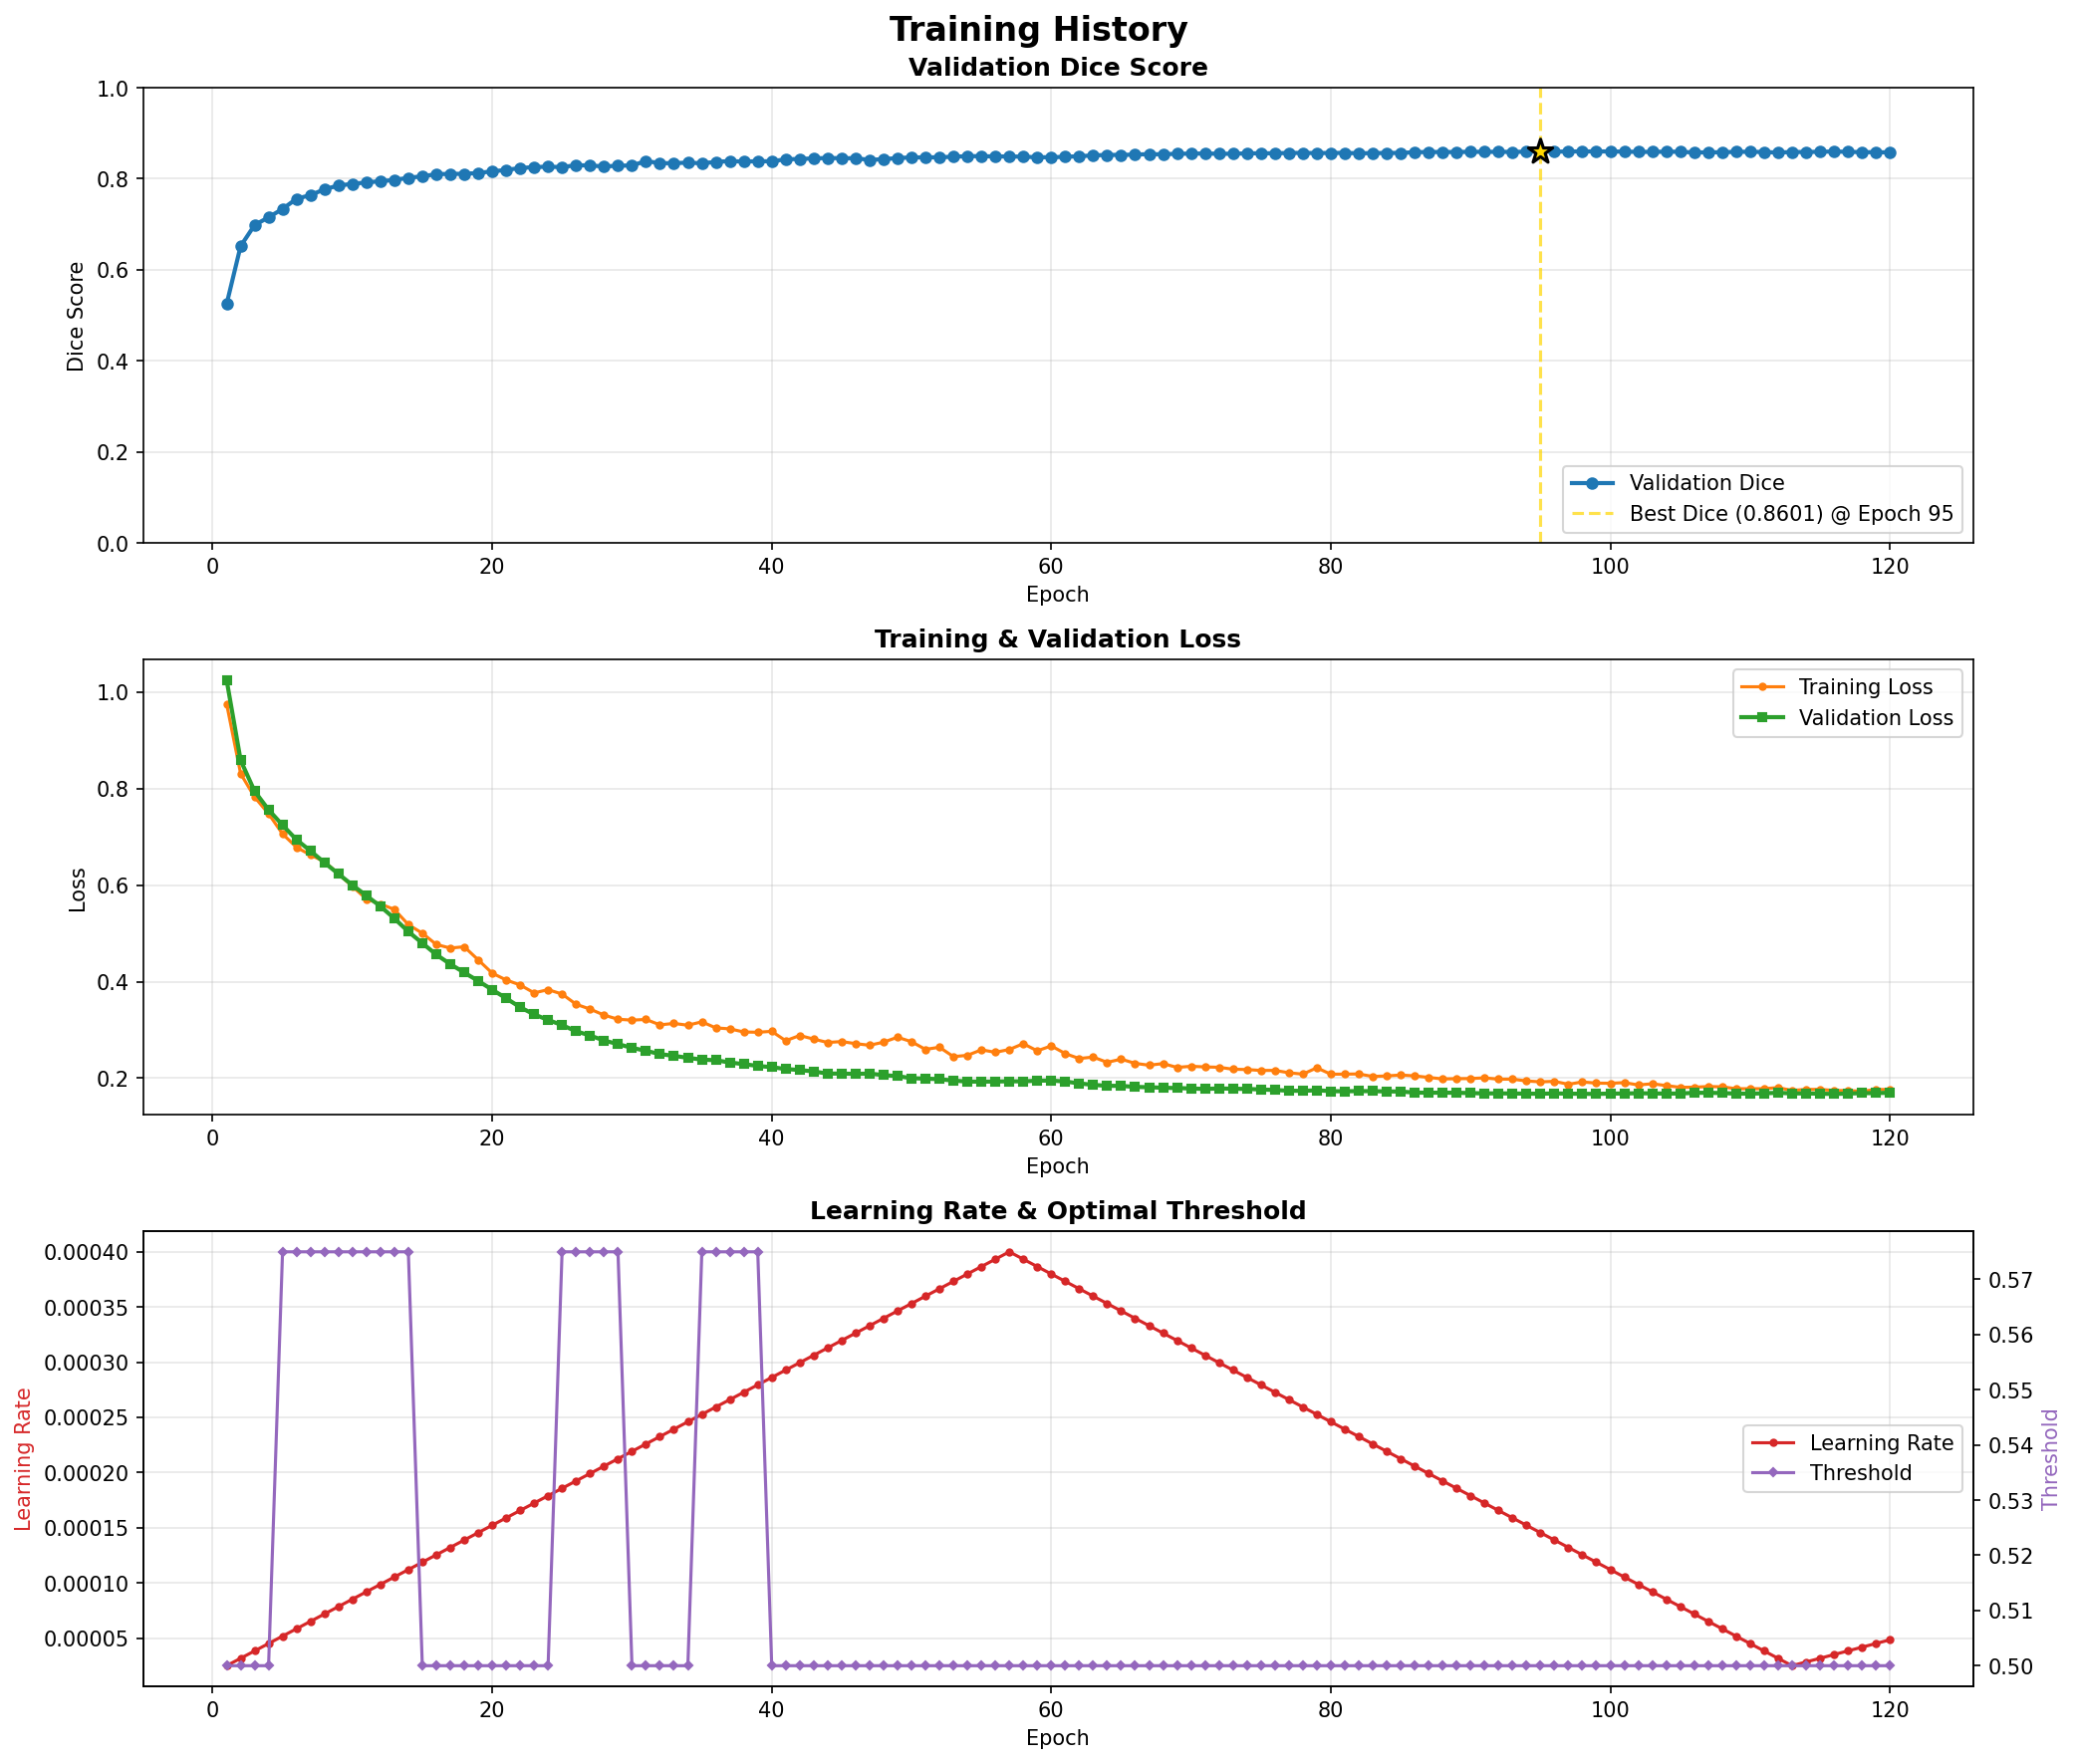

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

Final Dice: 0.8601 | Final IoU: 0.7558


In [9]:
# training history
history = {
    "epoch": [], "train_loss": [], "val_loss": [], "val_loss_dice": [],
    "val_loss_ce": [], "dice": [], "iou": [], "lr": [], "thr": [], "validated": []
}

print("Starting Training...")

best_metric = -1.0
best_epoch = -1
epochs_no_improve = 0
current_thr = CONFIG["init_threshold"]


# get the analogy based on the epoch
def get_curriculum(epoch):
    for stage in reversed(CONFIG["curriculum_stages"]):
        if epoch >= stage["epoch_start"]:
            return stage
    return CONFIG["curriculum_stages"][0]


# loop
for epoch in range(CONFIG["epochs"]):
    # Curriculum update
    curr_stage = get_curriculum(epoch)
    if epoch == curr_stage["epoch_start"]:
        train_dataset.transform = rand_transform(curr_stage["pos"], curr_stage["neg"])
        print(f"\n[Curriculum] Epoch {epoch+1}: {curr_stage['desc']} (pos={curr_stage['pos']}, neg={curr_stage['neg']})")

    # Training
    model.train()
    train_loss_sum = 0.0
    train_batches = 0

    # Memory monitoring
    if epoch == 0:
        print(f"[Memory] Before training: {torch.cuda.memory_allocated()/1e9:.2f} GB allocated")

    pbar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']} [Train]", leave=False)
    optimizer.zero_grad(set_to_none=True)

    for batch_idx, batch in enumerate(pbar_train, 1):
        x = batch["image"].to(device, non_blocking=True).float()
        y = batch["label"].to(device, non_blocking=True).float()

        try:
            x = x.to(memory_format=torch.channels_last_3d)
            y = y.to(memory_format=torch.channels_last_3d)
        except Exception:
            pass

        # Skip bad batches
        if not (torch.isfinite(x).all() and torch.isfinite(y).all()):
            print(f"[Warning] Skipping batch {batch_idx} - non-finite values")
            continue

        # Forward pass
        with torch.cuda.amp.autocast(enabled=True):
            logits = model(x)
            loss = criterion(logits, y)

        if not torch.isfinite(loss):
            print(f"[Warning] Skipping batch {batch_idx} - NaN/Inf loss")
            continue

        # Backward with accumulation
        loss_scaled = loss / CONFIG["accum_steps"]
        scaler.scale(loss_scaled).backward()

        if batch_idx % CONFIG["accum_steps"] == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0, error_if_nonfinite=False)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            ema.update(model)

        train_loss_sum += float(loss.detach())
        train_batches += 1

        pbar_train.set_postfix({"loss": f"{float(loss):.4f}"})

    # Handle remaining gradients
    if (batch_idx % CONFIG["accum_steps"]) != 0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0, error_if_nonfinite=False)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
        ema.update(model)

    avg_train_loss = train_loss_sum / max(train_batches, 1)

    # Validation
    do_validate = (epoch + 1) % CONFIG["val_every"] == 0
    val_metrics = None

    if do_validate:
        # Use EMA model for validation
        ema.apply(model)

        # Determine if we should sweep thresholds
        do_sweep = (epoch + 1) % CONFIG["thr_sweep_every"] == 0
        # Calculate component losses in final epochs
        calc_components = epoch > CONFIG["epochs"] - 20

        try:
            val_metrics = validate_model(
                model, val_loader,
                threshold=current_thr,
                do_threshold_sweep=do_sweep,
                calc_components=calc_components
            )
        except torch.cuda.OutOfMemoryError:
            print(f"[OOM] Validation failed at epoch {epoch+1}, skipping...")
            torch.cuda.empty_cache()
            val_metrics = (float('nan'), float('nan'), float('nan'), 0.0, 0.0, None, None)

        ema.restore(model)

        # Unpack metrics
        vloss, vloss_dice, vloss_ce, vdice, viou, best_thr, best_dice_sweep = val_metrics

        # Update threshold if sweep found a better one
        threshold_changed = ""
        if best_thr is not None and best_dice_sweep is not None and (best_dice_sweep - vdice) > 1e-3:
            old_thr = current_thr
            current_thr = best_thr
            threshold_changed = f" | thr {old_thr:.3f}→{current_thr:.3f}"

        # Check for improvement
        is_best = vdice > best_metric + CONFIG["min_delta"]
        if is_best:
            best_metric = vdice
            best_epoch = epoch + 1
            ema.apply(model)
            torch.save(model.state_dict(), CONFIG["best_model_path"])
            ema.restore(model)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Print summary
        print(f"[Epoch {epoch+1:03d}] "
              f"TrainLoss: {avg_train_loss:.4f} | "
              f"ValLoss: {vloss:.4f} | "
              f"ValDice@thr{current_thr:.2f}: {vdice:.4f} | "
              f"ValIoU: {viou:.4f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.2e}{threshold_changed} "
              f"{'| **NEW BEST**' if is_best else ''}")

        if calc_components and not np.isnan(vloss_dice):
            print(f"          └─ Loss Components - Dice: {vloss_dice:.4f}, CE: {vloss_ce:.4f}")

        # Record history
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(vloss)
        history["val_loss_dice"].append(vloss_dice)
        history["val_loss_ce"].append(vloss_ce)
        history["dice"].append(vdice)
        history["iou"].append(viou)
        history["lr"].append(optimizer.param_groups[0]["lr"])
        history["thr"].append(current_thr)
        history["validated"].append(True)

    else:
        print(f"[Epoch {epoch+1:03d}] TrainLoss: {avg_train_loss:.4f} | Validation: Skipped")

        history["epoch"].append(epoch + 1)
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(float('nan'))
        history["val_loss_dice"].append(float('nan'))
        history["val_loss_ce"].append(float('nan'))
        history["dice"].append(float('nan'))
        history["iou"].append(float('nan'))
        history["lr"].append(optimizer.param_groups[0]["lr"])
        history["thr"].append(current_thr)
        history["validated"].append(False)

    # Step scheduler
    scheduler.step()

    # Early stopping
    if epochs_no_improve >= CONFIG["patience"]:
        print(f"\n[Early Stopping] No improvement for {CONFIG['patience']} epochs. Best Dice: {best_metric:.4f} @ epoch {best_epoch}")
        break

    # Memory cleanup
    if (epoch + 1) % 10 == 0:
        torch.cuda.empty_cache()

print("")
print(f"Training Complete!")
print(f"Best Validation Dice: {best_metric:.4f} @ Epoch {best_epoch}")
print(f"Best Model Saved: {CONFIG['best_model_path']}")
print(f"Final Threshold: {current_thr:.3f}")
print("")

# plots
print("Generating plots...")

epochs = history["epoch"]
val_epochs = [e for e, v in zip(epochs, history["validated"]) if v]

fig, axes = plt.subplots(3, 1, figsize=(14, 12), dpi=150)
fig.suptitle('Training History', fontsize=16, fontweight='bold')

# dice
ax = axes[0]
ax.plot(val_epochs, [history["dice"][i-1] for i in val_epochs], 'o-',
        color='#1f77b4', linewidth=2, markersize=5, label='Validation Dice')
if best_epoch != -1:
    ax.axvline(x=best_epoch, color='gold', linestyle='--', alpha=0.7,
               label=f'Best Dice ({best_metric:.4f}) @ Epoch {best_epoch}')
    ax.scatter(best_epoch, best_metric, s=150, c='gold', marker='*',
               edgecolors='black', linewidth=1.5, zorder=5)
ax.set_title('Validation Dice Score', fontsize=12, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Dice Score')
ax.grid(True, alpha=0.3)
ax.legend(loc='lower right')
ax.set_ylim(0, 1)

# losses
ax = axes[1]
ax.plot(epochs, history["train_loss"], 'o-', color='#ff7f0e',
        linewidth=1.5, markersize=3, label='Training Loss')
ax.plot(val_epochs, [history["val_loss"][i-1] for i in val_epochs], 's-',
        color='#2ca02c', linewidth=2, markersize=4, label='Validation Loss')
ax.set_title('Training & Validation Loss', fontsize=12, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.grid(True, alpha=0.3)
ax.legend()

# other plots (learnign rate and threshold)
ax = axes[2]
ax_twin = ax.twinx()
line1 = ax.plot(epochs, history["lr"], 'o-', color='#d62728',
                linewidth=1.5, markersize=3, label='Learning Rate')
line2 = ax_twin.plot(val_epochs, [history["thr"][i-1] for i in val_epochs], 'D-',
                     color='#9467bd', linewidth=1.5, markersize=3, label='Threshold')
ax.set_title('Learning Rate & Optimal Threshold', fontsize=12, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Learning Rate', color='#d62728')
ax_twin.set_ylabel('Threshold', color='#9467bd')
ax.grid(True, alpha=0.3)
lines = line1 + line2
labs = [l.get_label() for l in lines]
ax.legend(lines, labs, loc='center right')

plt.tight_layout()
plt.savefig("training_history.png", dpi=300, bbox_inches='tight')
print("Plot saved: training_history.png")
plt.show()

model.load_state_dict(torch.load(CONFIG["best_model_path"]))
final_metrics = validate_model(model, val_loader, threshold=current_thr, do_threshold_sweep=True, calc_components=True)
print(f"Final Dice: {final_metrics[3]:.4f} | Final IoU: {final_metrics[4]:.4f}")